https://github.com/rickiepark/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb
케라스 창시자에게 배우는 딥러닝 코드 참조


캐런 시몬연과 앤드류 지서먼이 2014년에 개발한 VGG16 구조를 사용하겠습니다. VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁습니다. 하지만 이 모델의 구조가 이전에 보았던 것과 비슷해서 새로운 개념을 도입하지 않고 이해하기 쉽기 때문에 선택했습니다. 아마 VGG가 처음 보는 모델 애칭일지 모르겠습니다. 이런 이름에는 VGG, ResNet, Inception, Inception-ResNet, Xception 등이 있습니다


사전 훈련된 네트워크를 사용하는 두 가지 방법이 있습니다. 

# **특성 추출과 미세 조정**


왜 합성곱 층만 재사용할까요? 완전 연결 분류기도 재사용할 수 있을까요? 일반적으로 권장하지 않습니다. 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능하기 때문입니다.

컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있습니다. 더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않습니다. 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려합니다. 객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없습니다.

특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있습니다. 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출합니다. 반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출합니다. 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다.

ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다. 이런 경우 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 될 것 같습니다. 하지만 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반적인 경우를 다루기 위해서 여기서는 완전 연결 층을 사용하지 않겠습니다.

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. keras.applications 모듈에서 임포트할 수 있습니다. keras.applications 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련되었습니다):

Xception
InceptionV3
ResNet50
VGG16
VGG19
MobileNet


VGG16 모델을 만들어 보죠:

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

최종 특성 맵의 크기는 (4, 4, 512)입니다. 이 특성 위에 ***완전 연결 층***을 놓을 것입니다. 이 지점에서 두 가지 방식이 가능합니다.

새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 이 책의 1부에서 보았던 것과 비슷한 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.
준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

# **첫 번째 방식**

conv_base에 데이터를 주입하고 출력을 기록합니다. 이 출력을 새로운 모델의 입력으로 사용

먼저 앞서 소개한 ImageDataGenerator를 사용해 이미지와 레이블을 넘파이 배열로 추출하겠습니다. conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

In [ ]:
import os, shutil
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#base_dir = './datasets/cats_and_dogs_small'
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/data/.kaggle/"
original_dataset_dir = '/content/drive/My Drive/Colab Notebooks/data/.kaggle/train'
base_dir = '/content/cats_and_dogs'

In [ ]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.mkdir (base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join (base_dir, 'validation')
os.mkdir (validation_dir)
test_dir = os.path.join(base_dir,'test')
os.mkdir (test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [ ]:
# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다:

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
###setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

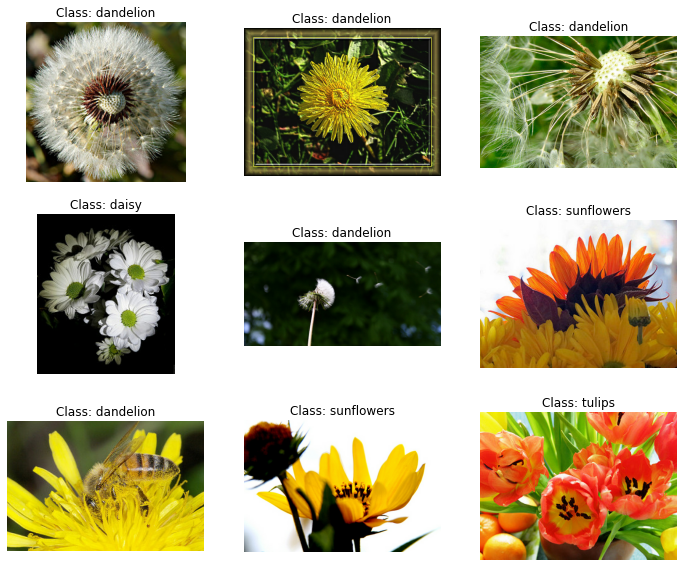

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
from functools import partial

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

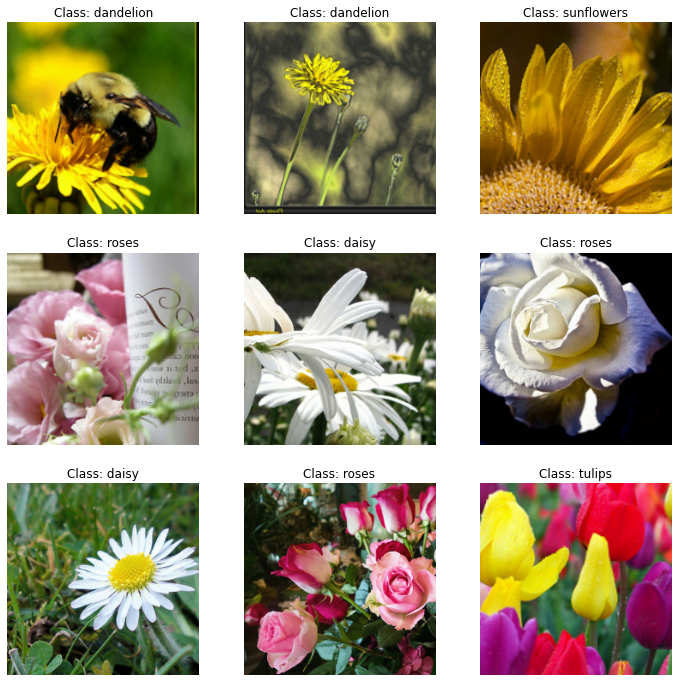

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()
